# Test Different Features, 1 step ahead

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [98]:
def read_dataset(filename, campaign=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving')]

    if campaign != None:
        df = df[df['campaign'] == campaign]

    if features == None:
        return df.drop(['Mode'], axis=1), df['Mode']
    else:
        X, y = df[features], df['Mode']
        return X, y


def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f): # check to see if we are bwyond the data set
            break

        if curr_campaign == '': # set new current campaign if there is np campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)
    return np.array(X), np.array(y)


def check_handover(y):
    new_y = [0]
    for i in range(len(y) - 1):
        if y[i] == y[i+1]:
            new_y.append(0)
        else:
            new_y.append(1)
    return np.array(new_y)

def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true)


def precision_recall(y_pred, y_true):
    tp, fp, fn =  0, 0, 0

    # Loop through true and predicted labels to count TP, FP, and FN
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            tp += 1
        elif yt == 0 and yp == 1:
            fp += 1
        elif yt == 1 and yp == 0:
            fn += 1

    # Precision calculation
    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    # Recall calculation
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)

    return precision, recall

In [99]:
def train_model(X, y):
    
    n_steps_in, n_steps_out = 3, 1
    X, y = series_split_sequences(X, y, n_steps_in, n_steps_out)

    train_size = len(y) // 3 * 2
    test_size = (len(y) - train_size) // 2

    X_train, y_train = X[len(y) - train_size ::], y[len(y) - train_size ::]
    X_val, y_val = X[0 : test_size], y[0 : test_size]
    X_test, y_test = X[test_size : len(y) - train_size], y[test_size : len(y) - train_size]
    y_test_changed = [i[0] for i in y_test]
    y_test_changed = check_handover(y_test_changed)

    n_features = X_train.shape[2]

    model = Sequential()
    model.add(LSTM(input_shape=(n_steps_in, n_features), units=10,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    model.add(LSTM(units=10,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy'],
                  optimizer='adam')
    

    model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)
    

    y_pred = model.predict(X_test)
    y_pred = (y_pred >= 0.5).astype(int)
    y_pred_changed = check_handover(y_pred)
    precision, recall = precision_recall(y_pred, y_test)
    acc = accuracy(y_pred, y_test)

    metrics = {'y_pred': y_pred, 
               'y_true': y_test,
               'n_5g_pred': sum(y_pred)[0],
               'n_5g_true': sum(y_test)[0],
               'n_ho_pred': sum(y_pred_changed),
               'n_ho_true': sum(y_test_changed),
               'Accuracy': acc, 
               'Precision': precision, 
               'Recall': recall}

    return metrics

In [100]:
metrics = {}

campaign='Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode'

feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'], 
                     ['RSRP', 'RSRQ'], ['RSRP', 'SINR'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'],
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

for fearures in feature_selection:
    used_features = ', '.join(fearures)
    fearures.append('campaign')
    X, y = read_dataset('datasets/Op1_merged.csv', campaign=campaign, features=fearures)
    metrics[used_features] = train_model(X, y)


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/ihneskarbovik/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [103]:
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')

df_metrics.reset_index(inplace=True)
df_metrics.rename(columns={'index': 'Combination'}, inplace=True)
df_metrics = df_metrics.drop(['y_pred', 'y_true'], axis=1)
df_metrics

,Combination,n_5g_pred,n_5g_true,n_ho_pred,n_ho_true,Accuracy,Precision,Recall
0,RSRP,0,390,0,11,0.645455,0.000000,0.000000
1,SINR,1,390,2,11,0.644545,0.000000,0.000000
2,RSRQ,63,390,4,11,0.595455,0.063492,0.010256
3,SSS_RSRP,0,390,0,11,0.645455,0.000000,0.000000
4,SSS_SINR,66,390,34,11,0.656364,0.590909,0.100000
5,SSS_RSRQ,0,390,0,11,0.645455,0.000000,0.000000
6,"RSRP, RSRQ",60,390,5,11,0.590909,0.000000,0.000000
7,"RSRP, SINR",8,390,4,11,0.638182,0.000000,0.000000
8,"SINR, RSRQ",44,390,8,11,0.609091,0.045455,0.005128
9,"RSRP, SINR, RSRQ",32,390,4,11,0.618182,0.031250,0.002564


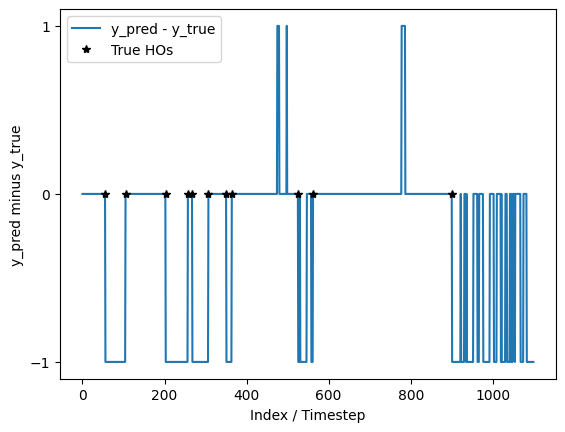

In [104]:
# looking at combination 'SSS_SINR, SSS_RSRQ'

comb = metrics['SSS_SINR, SSS_RSRQ']
y_pred = comb['y_pred']
y_true = comb['y_true']
hos = []

for i in range(len(check_handover(y_true))):
    if check_handover(y_true)[i] == 1:
        hos.append(i)

plt.plot(y_pred - y_true, label='y_pred - y_true')
plt.plot(hos, [0 for _ in range(len(hos))], '*', color='black', label='True HOs')
plt.yticks(range(-1, 2))
plt.xlabel('Index / Timestep')
plt.ylabel('y_pred minus y_true')
plt.legend()
plt.show()

y = -1: The model predicts 4G, but there is actually 5G

y = 1: The model predicts 5G, but there is actually 4G

y = 0: The model predicts correct